# Comércio Exterior Brasileiro - Estudo de Caso

**Autor:** Miquéias Araújo

O presente documento apresenta desde a extração de dados até a análise estatística do mesmo.

O foco desse documento é mostrar uma análise estatística dos dados disponíveis sobre o balanço do Comércio Exterior Brasileiro nos últimos 3 anos. Esses dados estão disponíveis no sequinte [link](https://www.gov.br/mdic/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta#Tabelas_Correlacoes).

Esse código foi desenvolvido em Python e faz de um projeto que possui ainda uma API e um dashboard para melhor visualização dos dados. Ambos disponíveis [aqui](https://github.com/MiqSA/app-data-visualization).

## Importa Bibliotecas

In [67]:
import pandas as pd
import requests
import io
import urllib.request
import json
import urllib3
from datetime import datetime
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import binom, poisson, hypergeom
import seaborn as sns

# Metodologia para varredura de arquivos

Verfica o ano atual e monta uma lista dos três últimos anos.

In [2]:
current_year = datetime.now().year
years = [current_year - i for i in range(3)]
years

[2023, 2022, 2021]

Verifica se existem arquivos disponíveis para os últimos três anos. Caso haja arquivos os mesmos são salvos em arquivo local em '.csv'. Caso não haja arquivos disponíveis o mesmo aponta uma mensagem de erro. Ademais é realizada a renomeação das colunas do arquivo disponível.

In [3]:
rename_columns = {'CO_ANO': 'ANO',
                  'CO_MES': 'MES',
                  'CO_NCM': 'COD_NCM',
                  'CO_UNID': 'COD_UNIDADE',
                  'CO_PAIS': 'COD_PAIS',
                  'SG_UF_NCM': 'SG_UF',
                  'CO_VIA': 'COD_VIA',
                  'CO_URF': 'COD_URF',
                  'QT_ESTAT': 'VL_QUANTIDADE',
                  'KG_LIQUIDO': 'VL_PESO_KG',
                 }

In [4]:
def get_data(years, type_mov='EXP'):
    for year in years:
        url = f'https://balanca.economia.gov.br/balanca/bd/comexstat-bd/ncm/{type_mov}_{year}.csv'
        urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

        data=requests.get(url, verify=False).content
        try:
            df=pd.read_csv(io.StringIO(data.decode('utf-8')), sep=';')
            df.rename(columns=rename_columns, inplace=True)
            df.to_csv(f'{type_mov}_{year}.csv')
            print(f'Sucesso: {type_mov}_{year}')
        except Exception as e:
            print("Servidor indisponível. Erro:", e)

# Exportações

In [5]:
get_data(years, type_mov='EXP')

Sucesso: EXP_2023
Sucesso: EXP_2022
Sucesso: EXP_2021


# Importações

In [6]:
get_data(years, type_mov='IMP')

Sucesso: IMP_2023
Sucesso: IMP_2022
Sucesso: IMP_2021


# Junção de Arquivos

Inicialmente, carrega-se os dados de dada movimentação dos últimos três anos.

In [7]:
def load_files(years, type_mov='EXP'):
    year_now = pd.read_csv(f'{type_mov}_{years[0]}.csv')
    year_now.drop(columns='Unnamed: 0', inplace=True)
    year_old = pd.read_csv(f'{type_mov}_{years[1]}.csv')
    year_old.drop(columns='Unnamed: 0', inplace=True)
    year_more_old = pd.read_csv(f'{type_mov}_{years[2]}.csv')
    year_more_old.drop(columns='Unnamed: 0', inplace=True)
    
    return year_now, year_old, year_more_old

Inicialmente, será realizada a junção dos arquivos de exportação.

In [8]:
exp_year_now, exp_year_old, exp_year_more_old = load_files(years, type_mov='EXP')

Após carregadas as bases de dados pode-se fazer a junção das mesmas. O que resulta no dataframe a seguir.

In [9]:
result = pd.concat([exp_year_now, exp_year_old, exp_year_more_old], ignore_index=True)
result

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB
0,2023,6,17019100,10,77,PA,1,217800,20,20,33
1,2023,1,39241000,10,628,SP,1,727600,304,304,62
2,2023,7,87089990,10,845,RS,7,1010351,1115,1115,10767
3,2023,11,84314910,10,845,SP,7,1010252,0,0,14
4,2023,4,12019000,21,160,MS,1,917800,431744,431737082,236330118
...,...,...,...,...,...,...,...,...,...,...,...
4407203,2021,8,27101999,10,845,RS,7,1010252,2448,2448,8426
4407204,2021,3,68022900,15,791,MG,1,717600,230,23861,45072
4407205,2021,4,85113020,11,586,SC,7,917501,20,2,27
4407206,2021,6,38241000,10,169,SP,1,817800,18600,18600,47080


Ajusta-se os dados do datraframe conforme requisitado: 'Acrescentando o zero à esquerda para algumas colunas'. Bem, como identifica que esse dataframe possui a movimentação de exportação.

In [10]:
result['COD_NCM'] = result['COD_NCM'].astype(str).str.pad(width=8, side='left', fillchar='0')
result['COD_URF'] = result['COD_URF'].astype(str).str.pad(width=7, side='left', fillchar='0')
result['COD_PAIS'] = result['COD_PAIS'].astype(str).str.pad(width=3, side='left', fillchar='0')
result['MOVIMENTACAO'] = 'Exportação'
result

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,MOVIMENTACAO
0,2023,6,17019100,10,077,PA,1,0217800,20,20,33,Exportação
1,2023,1,39241000,10,628,SP,1,0727600,304,304,62,Exportação
2,2023,7,87089990,10,845,RS,7,1010351,1115,1115,10767,Exportação
3,2023,11,84314910,10,845,SP,7,1010252,0,0,14,Exportação
4,2023,4,12019000,21,160,MS,1,0917800,431744,431737082,236330118,Exportação
...,...,...,...,...,...,...,...,...,...,...,...,...
4407203,2021,8,27101999,10,845,RS,7,1010252,2448,2448,8426,Exportação
4407204,2021,3,68022900,15,791,MG,1,0717600,230,23861,45072,Exportação
4407205,2021,4,85113020,11,586,SC,7,0917501,20,2,27,Exportação
4407206,2021,6,38241000,10,169,SP,1,0817800,18600,18600,47080,Exportação


Carrega os dados de importação dos últimos três anos e faz a junção dos dados.

In [11]:
imp_year_now, imp_year_old, imp_year_more_old = load_files(years, 'IMP')

In [12]:
result_imp = pd.concat([imp_year_now, imp_year_old, imp_year_more_old], ignore_index=True)
result_imp

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,VL_FRETE,VL_SEGURO
0,2023,7,84529081,10,858,SP,1,817800,1,1,208,0,0
1,2023,8,62114300,11,160,SP,4,817600,2302,586,26260,1340,11
2,2023,3,90229091,10,23,SP,4,817600,110,110,157185,2857,197
3,2023,7,76151000,10,249,SP,1,817800,26,26,839,3,0
4,2023,6,76169900,10,386,SP,4,817600,82,82,7842,1845,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932724,2021,7,84879000,10,355,SP,4,817600,3,3,112,106,0
5932725,2021,11,29224210,10,399,SP,4,817600,1,1,87,56,0
5932726,2021,3,29242999,10,767,SP,4,817700,0,0,557,23,0
5932727,2021,11,39202019,10,160,MS,1,817800,67,67,2002,40,42


Renomeia colunas.

In [13]:
result_imp['COD_NCM'] = result_imp['COD_NCM'].astype(str).str.pad(width=8, side='left', fillchar='0')
result_imp['COD_URF'] = result_imp['COD_URF'].astype(str).str.pad(width=7, side='left', fillchar='0')
result_imp['COD_PAIS'] = result_imp['COD_PAIS'].astype(str).str.pad(width=3, side='left', fillchar='0')
result_imp['MOVIMENTACAO'] = 'Importação'
result_imp

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,VL_FRETE,VL_SEGURO,MOVIMENTACAO
0,2023,7,84529081,10,858,SP,1,0817800,1,1,208,0,0,Importação
1,2023,8,62114300,11,160,SP,4,0817600,2302,586,26260,1340,11,Importação
2,2023,3,90229091,10,023,SP,4,0817600,110,110,157185,2857,197,Importação
3,2023,7,76151000,10,249,SP,1,0817800,26,26,839,3,0,Importação
4,2023,6,76169900,10,386,SP,4,0817600,82,82,7842,1845,6,Importação
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932724,2021,7,84879000,10,355,SP,4,0817600,3,3,112,106,0,Importação
5932725,2021,11,29224210,10,399,SP,4,0817600,1,1,87,56,0,Importação
5932726,2021,3,29242999,10,767,SP,4,0817700,0,0,557,23,0,Importação
5932727,2021,11,39202019,10,160,MS,1,0817800,67,67,2002,40,42,Importação


Após formado os dataframes de importação e exportação é necessário unir esses dataframes.

In [14]:
comex = pd.concat([result, result_imp], ignore_index=True)
comex 

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,MOVIMENTACAO,VL_FRETE,VL_SEGURO
0,2023,6,17019100,10,077,PA,1,0217800,20,20,33,Exportação,NaN,NaN
1,2023,1,39241000,10,628,SP,1,0727600,304,304,62,Exportação,NaN,NaN
2,2023,7,87089990,10,845,RS,7,1010351,1115,1115,10767,Exportação,NaN,NaN
3,2023,11,84314910,10,845,SP,7,1010252,0,0,14,Exportação,NaN,NaN
4,2023,4,12019000,21,160,MS,1,0917800,431744,431737082,236330118,Exportação,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339932,2021,7,84879000,10,355,SP,4,0817600,3,3,112,Importação,106.0,0.0
10339933,2021,11,29224210,10,399,SP,4,0817600,1,1,87,Importação,56.0,0.0
10339934,2021,3,29242999,10,767,SP,4,0817700,0,0,557,Importação,23.0,0.0
10339935,2021,11,39202019,10,160,MS,1,0817800,67,67,2002,Importação,40.0,42.0


# Salva o novo dataframe

In [15]:
comex.to_csv("f_comex.csv", index=False, sep=';', columns=comex.columns)


# Exclui arquivos

Alguns arquivos podem ser exlcuídos, pois apenas o arquivo 'f_comex.csv' é necessário.

In [16]:
for year in years:
    os.remove(f'EXP_{year}.csv')

In [17]:
for year in years:
    os.remove(f'IMP_{year}.csv')

# Análise dos Dados

A tabela que será feita a análise de dados é chamada aqui de `comex`. Basicamente, ela tem as aspecto mostrado a seguir. Nota-se que nos cinco primeiros registros já é possível ver algumas informações importantes como a existência de dados nulos (como no caso do `VL_FRETE` para o índice 0).

Há um [manual](https://balanca.economia.gov.br/balanca/manual/Manual.pdf) dos dados estatítiscos do Comércio Exterior Brasileiro que aponta o signicado de cada coluna. Ademais, algumas colunas apontam para outras tabelas, como no caso do `COD_NCM` aponta para tabela de `NCM.csv`em que mostra informações do produto que foi exportado ou importado. Todas as tabelas auxiliares estão disponíveis [aqui](https://www.gov.br/mdic/pt-br/assuntos/comercio-exterior/estatisticas/base-de-dados-bruta#Tabelas_Correlacoes).

In [63]:
comex.head()

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,MOVIMENTACAO,VL_FRETE,VL_SEGURO
0,2023,6,17019100,10,077,PA,1,0217800,20,20,33,Exportação,NaN,NaN
1,2023,1,39241000,10,628,SP,1,0727600,304,304,62,Exportação,NaN,NaN
2,2023,7,87089990,10,845,RS,7,1010351,1115,1115,10767,Exportação,NaN,NaN
3,2023,11,84314910,10,845,SP,7,1010252,0,0,14,Exportação,NaN,NaN
4,2023,4,12019000,21,160,MS,1,0917800,431744,431737082,236330118,Exportação,NaN,NaN


É interessante saber o tamanho da amostra. Nesse sentido, o comando a seguir mostra que trata-se de uma tabela com mais de 10 milhoões de registros divididos em 14 colunas diferentes.

In [19]:
comex.shape

(10339937, 14)

Como já verificado no início dessa análise alguns dados paracem estar faltando nessa base de dados. Contudo, não se verificou a quantidade desses dados. Assim, a seguir é feita a contagem de dados por coluna da base de dados. Nota-se que para as colunas `VL_FRETE` e `VL_SEGURO` há dados faltando.

In [20]:
count = comex.count()
count

ANO              10339937
MES              10339937
COD_NCM          10339937
COD_UNIDADE      10339937
COD_PAIS         10339937
SG_UF            10339937
COD_VIA          10339937
COD_URF          10339937
VL_QUANTIDADE    10339937
VL_PESO_KG       10339937
VL_FOB           10339937
MOVIMENTACAO     10339937
VL_FRETE          5932729
VL_SEGURO         5932729
dtype: int64

Uma das primeiras perguntas que pode ser feita: Como foi as movimentações do comércio exterior brasileiro nesses últimos anos?

A seguir são verificados por `ANO` e `MOVIMENTACAO` os dados. Percebe-se que mais importamos que exportamos nos últimos anos. Ademais, no corrente ano parece haver uma desaceleração em relação aos demais anos, inclusive 2021. Contudo, isso pode estar acontecendo devido aos dados ainda deste ano não terem sido todos computados. 

Observa-se ainda que tanto para importação como para exportação no ano de 2022 houve crescimento em relação a 2021.

In [95]:
comex_by_year_mov = comex[["ANO", "MOVIMENTACAO"]].value_counts().reset_index(name='count')
comex_by_year_mov 

,ANO,MOVIMENTACAO,count
0,2022,Importação,2023256
1,2021,Importação,1999946
2,2023,Importação,1909527
3,2022,Exportação,1495868
4,2021,Exportação,1480295
5,2023,Exportação,1431045


(1400000.0, 2200000.0)

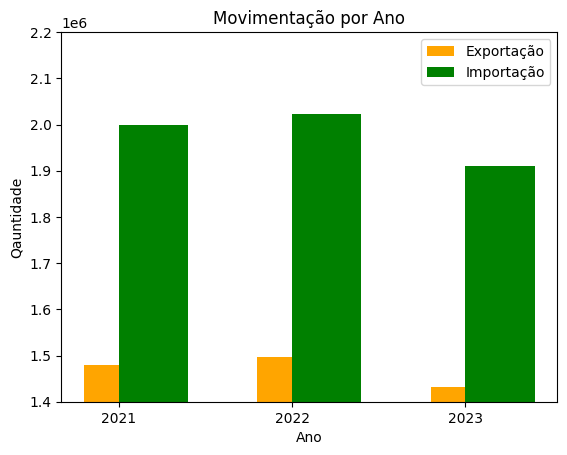

In [156]:
_exportac = comex_by_year_mov[comex_by_year_mov ['MOVIMENTACAO'] == 'Exportação']
_importac = comex_by_year_mov[comex_by_year_mov ['MOVIMENTACAO'] == 'Importação']

fig, ax = plt.subplots()

# Use the index as x-axis, and 'count' as y-axis for each bar
rects1 = ax.bar(_exportac['ANO'], _exportac['count'], width=0.4, align='center', label='Exportação', color='orange')
rects2 = ax.bar(_importac['ANO'], _importac['count'], width=0.4, align='edge', label='Importação', color='green')

ax.set_ylabel('Qauntidade')
ax.set_xlabel('Ano')
ax.set_title('Movimentação por Ano')

# Customize the x-axis ticks and labels
ax.set_xticks(comex_by_year_mov['ANO'].unique())
ax.legend()
plt.ylim([1400000, 2200000])



Seguindo na análise é possível usar uma função chamada `describe()` que descreve com dados estatísticos o dataframe que está sendo estudado.

In [23]:
?comex.describe

Signature: comex.describe(percentiles=None, include=None, exclude=None) -> 'Self'
Docstring:
Generate descriptive statistics.

Descriptive statistics include those that summarize the central
tendency, dispersion and shape of a
dataset's distribution, excluding ``NaN`` values.

Analyzes both numeric and object series, as well
as ``DataFrame`` column sets of mixed data types. The output
will vary depending on what is provided. Refer to the notes
below for more detail.

Parameters
----------
percentiles : list-like of numbers, optional
    The percentiles to include in the output. All should
    fall between 0 and 1. The default is
    ``[.25, .5, .75]``, which returns the 25th, 50th, and
    75th percentiles.
include : 'all', list-like of dtypes or None (default), optional
    A white list of data types to include in the result. Ignored
    for ``Series``. Here are the options:

    - 'all' : All columns of the input will be included in the output.
    - A list-like of dtypes : Limits th

Obviamente, cabe uma análise do tipo de dado e o significado de cada estatística. Por exemplo, segundo o manual dos dados do Comércio Exterior Brasileiro o `VL_QUANTIDADE` pode mudar por produto (`COD_NCM`), isso implica que em alguns produtos esta quantidade é uma medida de quilo e para outro é uma medida em dólars. Em todo caso não se pode somar tudo, sem os devidos filtros por produtos. Já o valor do FOB é padronizado em dólar e indica o preço da mercadoria em dólares americanos sob o Incoterm FOB
(Free on Board), modalidade na qual o vendedor é responsável por embarcar a mercadoria
enquanto o comprador assume o pagamento do frete, seguros e demais custos pós embarque.
Nesse caso, o valor informado da mercadoria expressa o valor exclusivamente da mercadoria.

In [24]:
comex.describe()

,ANO,MES,COD_UNIDADE,COD_VIA,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,VL_FRETE,VL_SEGURO
count,1.033994e+07,1.033994e+07,1.033994e+07,1.033994e+07,1.033994e+07,1.033994e+07,1.033994e+07,5.932729e+06,5.932729e+06
mean,2.021986e+03,6.436997e+00,1.055871e+01,2.819851e+00,2.267676e+05,2.590441e+05,1.585168e+05,7.635879e+03,9.149856e+01
std,8.120805e-01,3.334307e+00,1.270339e+00,2.201784e+00,2.352572e+07,2.488275e+07,3.816015e+06,9.169808e+04,2.816979e+03
min,2.021000e+03,1.000000e+00,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.021000e+03,4.000000e+00,1.000000e+01,1.000000e+00,4.000000e+00,4.000000e+00,2.110000e+02,1.900000e+01,0.000000e+00
50%,2.022000e+03,6.000000e+00,1.000000e+01,1.000000e+00,4.800000e+01,4.800000e+01,2.057000e+03,2.240000e+02,1.000000e+00
75%,2.023000e+03,9.000000e+00,1.100000e+01,4.000000e+00,1.150000e+03,1.091000e+03,2.010500e+04,1.641000e+03,1.200000e+01
max,2.023000e+03,1.200000e+01,2.200000e+01,1.500000e+01,1.430018e+10,2.403087e+10,2.102966e+09,2.341572e+07,1.760480e+06


Para melhor visualização podemos agrupar por ano e ver o `VL_PESO_KG` dos produtos e seu `VL_FOB`. E ver algumas medidas estatísticas por ano.

In [160]:
grouped_by_year = comex.groupby('ANO')
summary_statistics = grouped_by_year.agg({
    'VL_FOB': ['count', 'mean', 'median', 'min', 'max', 'var', 'std'],
    'VL_PESO_KG': ['mean', 'median', 'min', 'max', 'var', 'std'],
})
summary_statistics

VL_FOB                                                       \
        count           mean  median min         max           var   
ANO                                                                  
2021  3480241  143732.180225  2025.0   0  2102966398  1.635114e+13   
2022  3519124  172414.136349  2141.0   0  1100695368  1.355867e+13   
2023  3340572  159279.341217  2006.0   0  1258491165  1.375449e+13   

                       VL_PESO_KG                                        \
               std           mean median min          max           var   
ANO                                                                       
2021  4.043655e+06  252510.642894   50.0   0  14300175000  6.005167e+14   
2022  3.682210e+06  259761.488863   49.0   0  24030871000  7.108154e+14   
2023  3.708705e+06  265095.023156   45.0   0  14101301000  5.420023e+14   

                    
               std  
ANO                 
2021  2.450544e+07  
2022  2.666112e+07  
2023  2.328094e+07

É interessante ainda notar que há casos que o `VL_QUANTIDADE` é zero. Mas o `VL_FOB` não, indicando a permanência de alguns produtos embarcados. Sendo um total de 668.704 ocorrências deste tipo.

In [162]:
df = comex.query('VL_QUANTIDADE == 0')
df

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,MOVIMENTACAO,VL_FRETE,VL_SEGURO
3,2023,11,84314910,10,845,SP,7,1010252,0,0,14,Exportação,NaN,NaN
33,2023,1,83023000,10,586,MG,7,0917500,0,0,2,Exportação,NaN,NaN
34,2023,9,73043920,10,069,SP,1,0817800,0,0,2,Exportação,NaN,NaN
48,2023,3,73182400,10,493,RS,4,0817700,0,0,54,Exportação,NaN,NaN
55,2023,1,39269090,10,249,RJ,4,0717700,0,0,2136,Exportação,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10339891,2021,6,39199020,10,670,RJ,1,0817800,0,0,13,Importação,0.0,0.0
10339898,2021,2,90279099,10,249,RS,4,0817600,0,0,1194,Importação,540.0,60.0
10339905,2021,10,83024900,10,375,SP,4,0817700,0,0,190,Importação,7.0,0.0
10339920,2021,11,73261900,10,386,MG,4,0717700,0,0,2,Importação,0.0,0.0


Pode-se analisar ainda por estado brasileiro.

In [32]:
grouped_by_state = comex[["ANO", "MES", "SG_UF", "MOVIMENTACAO", "VL_QUANTIDADE"]]
mean_by_state = grouped_by_state.groupby(["ANO","SG_UF", "MOVIMENTACAO", "MES"]).sum()
mean_by_state

VL_QUANTIDADE
ANO  SG_UF MOVIMENTACAO MES               
2021 AC    Exportação   1          2413628
                        2          2146092
                        3          2191523
                        4          2252796
                        5          1515689
...                                    ...
2023 TO    Importação   7         21987787
                        8         19903561
                        9         48759441
                        10        32905700
                        11        28763686

[1944 rows x 1 columns]

O estado que mais teve `VL_QUANTIDADE` foi o Pará em 2022 no mês de setembro na modalidade exportação

In [33]:
largest_movement_state = mean_by_state['VL_QUANTIDADE'].idxmax()
largest_movement_state

(2022, 'PA', 'Exportação', 9)

In [34]:
vl_quantidade_mean = mean_by_state.loc[(2022, 'PA', 'Exportação', 9), 'VL_QUANTIDADE']
vl_quantidade_mean

19180196807

In [35]:
comex['VL_QUANTIDADE'].idxmax()

4193920

Assim, pode-se analisar qual produto foi mais exportado em termos de `VL_QUANTIDADE`, que nesse caso, é o mesmo valor do `VL_PESO_KG`. Analisando o `COD_NCM` pode-se concluir que trata-se de `Minérios de ferro e seus concentrados, exceto as piritas de ferro ustuladas (cinzas de piritas), não aglomerados`. O país para qual foi exportado foi a `CHINA` pela via `MARITIMA`.

In [36]:
comex.loc[4193920]

ANO                     2021
MES                        9
COD_NCM             26011100
COD_UNIDADE               10
COD_PAIS                 160
SG_UF                     PA
COD_VIA                    1
COD_URF              0317903
VL_QUANTIDADE    14300175000
VL_PESO_KG       14300175000
VL_FOB            1808501568
MOVIMENTACAO      Exportação
VL_FRETE                 NaN
VL_SEGURO                NaN
Name: 4193920, dtype: object

In [42]:
df_sorted = comex.sort_values(by='VL_QUANTIDADE', ascending=False)

In [43]:
df_sorted

,ANO,MES,COD_NCM,COD_UNIDADE,COD_PAIS,SG_UF,COD_VIA,COD_URF,VL_QUANTIDADE,VL_PESO_KG,VL_FOB,MOVIMENTACAO,VL_FRETE,VL_SEGURO
4193920,2021,9,26011100,10,160,PA,1,0317903,14300175000,14300175000,1808501568,Exportação,NaN,NaN
724015,2023,8,26011100,10,160,PA,1,0317903,14101301000,14101301000,1091011415,Exportação,NaN,NaN
2510025,2022,9,26011100,10,160,PA,1,0317903,13916980000,13916980000,1016435350,Exportação,NaN,NaN
4317521,2021,10,26011100,10,160,PA,1,0317903,13243266000,13243266000,1327418213,Exportação,NaN,NaN
538486,2023,9,26011100,10,160,PA,1,0317903,12912081920,12912081920,991786572,Exportação,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
843354,2023,10,73079900,10,647,RS,4,0817700,0,0,22,Exportação,NaN,NaN
4909316,2023,8,29121999,10,160,SP,4,0817600,0,0,12,Importação,2.0,0.0
843353,2023,4,39199090,10,603,MG,4,0817600,0,5,2,Exportação,NaN,NaN
4909318,2023,1,84149010,10,361,SP,4,0817700,0,0,14,Importação,2.0,0.0


Por fim, feito o tratamento dos dados e expostos em um dashboard. Para usá-lo basta seguir as [instruções](https://github.com/MiqSA/app-data-visualization?tab=readme-ov-file#app-de-visualiza%C3%A7%C3%A3o-de-dados).